## CQR using LGBM algorithm on **dense** dataset.

In [1]:
%matplotlib inline

In [1]:
!pip install torchvision

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://artifactory.michelin.com/api/pypi/pypi/simple
     |████████████████████████████████| 19.1 MB 5.2 MB/s eta 0:00:01|████████▊                       | 5.2 MB 5.2 MB/s eta 0:00:03███▊               | 10.0 MB 5.2 MB/s eta 0:00:02
     |████████████████████████████████| 3.1 MB 47.4 MB/s eta 0:00:01
     |████████████████████████████████| 776.3 MB 1.7 kB/s s eta 0:00:01                 | 4.3 MB 43.0 MB/s eta 0:00:18 MB 43.0 MB/s eta 0:00:1818                           | 54.4 MB 43.0 MB/s eta 0:00:17                       | 61.8 MB 43.0 MB/s eta 0:00:17     |██▊                             | 65.6 MB 46.5 MB/s eta 0:00:16 MB 46.5 MB/s eta 0:00:16     |███▍                            | 81.3 MB 46.5 MB/s eta 0:00:15     |█████▎                          | 127.4 MB 37.9 MB/s eta 0:00:18█▋                          | 136.0 MB 37.9 MB/s eta 0:00:177.9 MB/s eta 0:00:17MB 37.9 MB/s eta 0:00:17MB 37

In [2]:
import torch
import random
import numpy as np
np.warnings.filterwarnings('ignore')


seed = 1

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# desired miscoverage error
alpha = 0.1

# desired quanitile levels
quantiles = [0.05, 0.95]

# used to determine the size of test set
test_ratio = 0.2



In [3]:
import warnings

import matplotlib.pyplot as plt
from matplotlib.offsetbox import (TextArea, AnnotationBbox)
from matplotlib.ticker import FormatStrFormatter
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV, train_test_split, KFold
from scipy.stats import randint, uniform
from typing import Tuple, Dict

from mapie._typing import ArrayLike, NDArray
from mapie.metrics import (
    regression_coverage_score,
    regression_mean_width_score
    )
from mapie.regression import MapieRegressor
from mapie.subsample import Subsample
from mapie.quantile_regression import MapieQuantileRegressor


In [4]:
from libraries import *

2022-09-12 10:35:15.353951: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-09-12 10:35:15.359133: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-12 10:35:15.359147: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load Data

In [5]:
data = pd.read_excel("../../../Data/dense_data.xlsx")
y = data["RRc MIRRI"]
X = data.drop(["Unnamed: 0", "RRc MIRRI", "Sre_ID"], axis=1)
def select_columns(df, col_type=None):
    """
    Select columns from a dataframe by type.
    """
    if col_type == "numerical":
        return df.select_dtypes(exclude=['object'])
    elif col_type == "categorical":
        return df.select_dtypes(include=['object'])
    else:
        raise ValueError("col_type should be numerical or categorical")

# Create the preprocessing pipelines for numerical data.
numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean', verbose=1)),
        ('scaler', StandardScaler())])

# Create the preprocessing pipelines for categorical data.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing',verbose=1)),
    ('onehot', OneHotEncoder(categories='auto',sparse=False,handle_unknown='ignore'))])

# Combine all elements of preprocessor
preprocessor = Pipeline(steps=[
        ("union", FeatureUnion(transformer_list=[
    ('numerical', Pipeline(steps=[
        ('get_num_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="numerical"))),
        ('transformer', numerical_transformer)])),
    ('categorical', Pipeline(steps=[
        ('get_cat_cols', FunctionTransformer(select_columns, kw_args=dict(col_type="categorical"))),
        ('transformer',categorical_transformer)]))
    ])) 
])
X_encoded = preprocessor.fit_transform(X)

In [6]:
TEST_SIZE = 0.1 #define test size 0.1 = 10% of the data
CALIB_SIZE = 0.2
#split data
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,test_size=TEST_SIZE)
X_train, X_calib, y_train, y_calib = train_test_split(X_train, y_train, test_size = CALIB_SIZE)

print(f"\nX_train : {len(X_train)}  |  y_train : {len(y_train)} ")
print(f"X_test : {len(X_test)}  |  y_test : {len(y_test)} ")
print(f"X_calib : {len(X_calib)}  |  y_calib : {len(y_calib)} ")



X_train : 5265  |  y_train : 5265 
X_test : 732  |  y_test : 732 
X_calib : 1317  |  y_calib : 1317 


## 2. Optimizing estimator LGBM
Optimization of the `LGBMRegressor` using `RandomizedSearchCV` to find the
optimal model to predict the house prices.



In [20]:
#####################################################
# Neural network parameters
# (See AllQNet_RegressorAdapter class in helper.py)
#####################################################

# pytorch's optimizer object
nn_learn_func = torch.optim.Adam

# number of epochs
epochs = 1000

# learning rate
lr = 0.0005

# mini-batch size
batch_size = 64

# hidden dimension of the network
hidden_size = 64

# dropout regularization rate
dropout = 0.1

# weight decay regularization
wd = 1e-6

# Ask for a reduced coverage when tuning the network parameters by 
# cross-validataion to avoid too concervative initial estimation of the 
# prediction interval. This estimation will be conformalized by CQR.
quantiles_net = [0.1, 0.9]

In [19]:
# define quantile neural network model
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=in_shape,
                                                     hidden_size=hidden_size,
                                                     quantiles=quantiles_net,
                                                     learn_func=nn_learn_func,
                                                     epochs=epochs,
                                                     batch_size=batch_size,
                                                     dropout=dropout,
                                                     lr=lr,
                                                     wd=wd,
                                                     test_ratio=cv_test_ratio,
                                                     random_state=cv_random_state,
                                                     use_rearrangement=False)

# define a CQR object, computes the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qnet, length_cp_qnet = helper.compute_coverage(y_test,
                                                           y_lower,
                                                           y_upper,
                                                           alpha,
                                                           "CQR Neural Net")

NameError: name 'helper' is not defined

## Use CQR to get Quantiles

In [7]:
STRATEGIES = {
    "cqr": {"method": "quantile", "cv": "split", "alpha": 0.1},
}
y_pred, y_pis = {}, {}
y_pred_train, y_pis_train = {}, {}

coverage, width = {}, {}

for strategy, params in STRATEGIES.items():
    if strategy == "cqr":
        mapie = MapieQuantileRegressor(estimator, **params)  # type: ignore
        mapie.fit(X_train, y_train, X_calib=X_calib, y_calib=y_calib)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test)
        y_pred_train[strategy], y_pis_train[strategy] = mapie.predict(X_train)
    else:
        mapie = MapieRegressor(estimator, **params)  # type: ignore
        mapie.fit(X_train, y_train)
        y_pred[strategy], y_pis[strategy] = mapie.predict(X_test, alpha=0.2)
    
    coverage[strategy] = np.round(regression_coverage_score(
        y_test,
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        ), round_to)
    width[strategy] = np.round(regression_mean_width_score(
        y_pis[strategy][:, 0, 0],
        y_pis[strategy][:, 1, 0]
        ), round_to)

In [8]:
pred_test = y_pred['cqr']
lower_test = y_pis['cqr'][:, 0, 0]
upper_test = y_pis['cqr'][:, 1, 0]
mediane_test = mapie.estimators_[2].predict(X_test)

In [9]:
pred_train = y_pred_train['cqr']
lower_train = y_pis_train['cqr'][:, 0, 0]
upper_train = y_pis_train['cqr'][:, 1, 0]
mediane_train = mapie.estimators_[2].predict(X_train)

<AxesSubplot:xlabel='Residual error', ylabel='Density'>

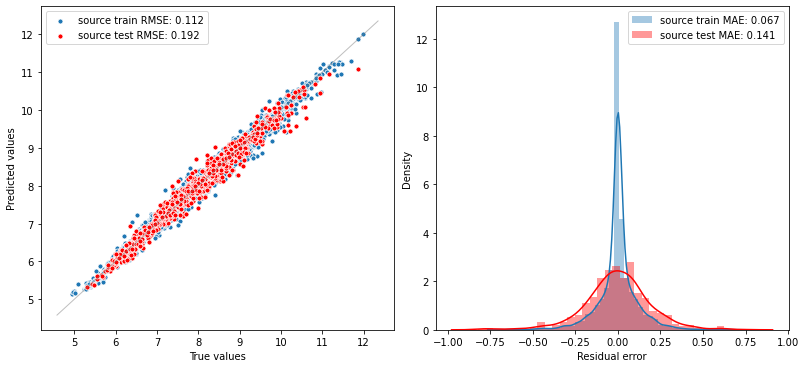

In [10]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs[0, 1]); 

plot_adequation(y_train, pred_train, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, pred_test, label='source test', ax=ax1, plot_line=False, score='RMSE', color='red')



plot_residuals(y_train, pred_train, kind='hist', label='source train', ax=ax2, score='MAE')
plot_residuals(y_test, pred_test, kind='hist', label='source test', ax=ax2, score='MAE', color='red')

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

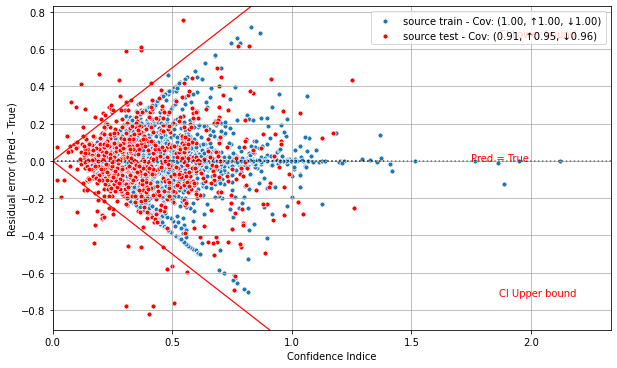

In [11]:
fig = plt.figure(constrained_layout=True, figsize=(24, 14))
gs = fig.add_gridspec(3, 3)

ax1 = fig.add_subplot(gs[0, 0])
plt.grid(True)

plot_confidence_v2(y_train,pred_train , lower_train,  upper_train, ax=ax1, label='source train')
plot_confidence_v2(y_test,pred_test, lower_test,  upper_test, ax=ax1, color='red', label='source test')

In [12]:
p0_05 = lower_test.copy()
p0_5 = mediane_test.copy()
p0_95 = upper_test.copy()

In [13]:
def pearson_tukey(p0_05, p0_5, p0_95):
    mu = 0.63*p0_5 + 0.185*(p0_05+p0_95)
    std = 0.63*(p0_5-mu)**2+0.185*((p0_05-mu)**2 + (p0_95-mu)**2)
    return mu, std

In [14]:
mu, stds = pearson_tukey(p0_05, p0_5, p0_95)

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

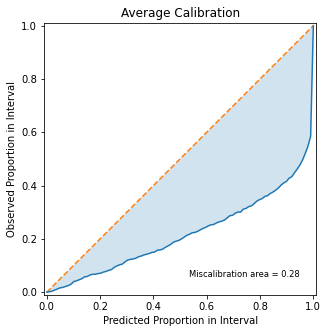

In [15]:
uct.viz.plot_calibration(np.array(pred_test),  np.array(stds), np.array(y_test))

In [16]:
all_metrics = uct.get_all_metrics(np.array(pred_test),np.array(stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.33it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.65it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.141
  RMSE          0.192
  MDAE          0.102
  MARPD         1.767
  R2            0.974
  Correlation   0.987
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.319
  Mean-absolute Calibration Error       0.280
  Miscalibration Area                   0.283
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.327
     Group Size: 0.56 -- Calibration Error: 0.292
     Group Size: 1.00 -- Calibration Error: 0.280
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.373
     Group Size: 0.56 -- Calibration Error: 0.336
     Group Size: 1.00 -- Calibration Error: 0.319
================

In [17]:
recalibrator = uct.recalibration.get_std_recalibrator(np.array(pred_test), np.array(stds), np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(stds))

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

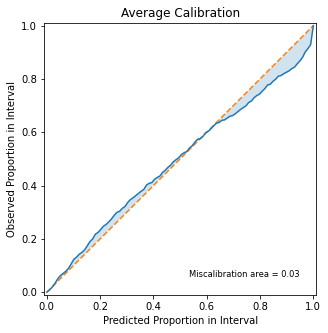

In [18]:
uct.viz.plot_calibration(np.array(pred_test),  np.array(new_stds), np.array(y_test))

In [19]:
all_metrics_calib = uct.get_all_metrics(np.array(pred_test),np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.79it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.18it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           0.141
  RMSE          0.192
  MDAE          0.102
  MARPD         1.767
  R2            0.974
  Correlation   0.987
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.038
  Mean-absolute Calibration Error       0.030
  Miscalibration Area                   0.030
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.077
     Group Size: 0.56 -- Calibration Error: 0.039
     Group Size: 1.00 -- Calibration Error: 0.030
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.085
     Group Size: 0.56 -- Calibration Error: 0.048
     Group Size: 1.00 -- Calibration Error: 0.038
================